# Copula by Ratio Estimation

For a copula denity $c(F_1(x_1),F_2(x_2))=\frac{h(x_1,x_2)}{f_1(x_1)\cdot f_2(x_2)}$, we can reinterpret this as a ratio $\frac{p(x_1,x_2)}{q(x_1,x_2)}=r(x_1,x_2) \in \mathbb{R}^{+}$.

With this insight, let us use density ratio estimation methods to recover the copula density $c$. We will train a classifier given samples from $p$ and $q$, depending on a parameterised function $r_\theta:\mathcal{X}\rightarrow\mathbb{R}^{+}$ to optimise the logistic loss:
$$
\mathcal{L}(\boldsymbol{\theta})=-\mathbb{E}_{\mathbf{x}_1 \sim p} \log \left(\frac{r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}{1+r\left(\mathbf{x}_1 ; \boldsymbol{\theta}\right)}\right)-\mathbb{E}_{\mathbf{x}_2 \sim q} \log \left(\frac{1}{1+r\left(\mathbf{x}_2 ; \boldsymbol{\theta}\right)}\right)
$$

### $r_\theta$ as a linear regression of $(x_1,x_2,x_1^{2},x_2^2,x_1\cdot x_2)$

Let $c(u,v)=\frac{N_2(x_1,x_2)}{N(x_1)\cdot N(x_2)}$ and $f_1(x),f_2(x)=N(x)$

C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\patches.py:742: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
C:\Users\u1819911\AppData\Roaming\Python\Python39\site-packages\matplotlib\patches.py:743: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)


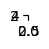

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(0,0))
plt.plot([1,2,3,4])
plt.show()

c:\Users\u1819911\Anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


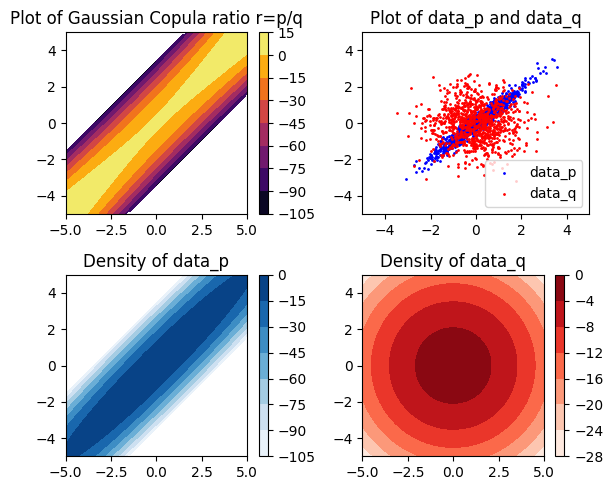

In [2]:

import torch
import numpy as np


# Gaussian helper functions
def pdf_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).log_prob(input).exp()

def inverse_std_normal(input):
  return torch.distributions.normal.Normal(loc = 0, scale = 1).icdf(input)

def bvn_density(rho, x, y, shift = 0.0, scale = 1.0):

   mean = torch.tensor([shift, shift])
   covariance_matrix = torch.tensor([[scale, rho], [rho, scale]])
   multivariate_normal = torch.distributions.MultivariateNormal(mean, covariance_matrix)

   l = len(x)
   input = torch.cat([x.reshape(l, 1), y.reshape(l, 1)], dim=1)

   return multivariate_normal.log_prob(input).exp()

def GC_density(rho, x, y):

  f_1 = pdf_std_normal(x).log()
  f_2 = pdf_std_normal(y).log()
  low = f_1 + f_2

  up = bvn_density(rho = rho, x = x, y = y).log()

  return (up - low).exp()

N = 1000
data_p = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0.97], [0.97, 1.0]])).sample((N,))
data_q = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), torch.tensor([[1.0, 0], [0, 1.0]])).sample((N,))

## Plots of Gaussian Copula (the ratio r), and samples from p and q
xline = torch.linspace(-5, 5, 100)
yline = torch.linspace(-5, 5., 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
uvinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

px = GC_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1])

fig, axs = plt.subplots(2, 2, figsize=(6, 5))  

# Plot of Gaussian Copula ratio r=p/q
contour_plot = axs[0, 0].contourf(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100).log(), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0, 0]) 
axs[0, 0].set_title('Plot of Gaussian Copula ratio r=p/q')

# Plot of data_p and data_q
axs[0, 1].scatter(data_p[:, 0], data_p[:, 1], s=1, color='blue', label='data_p')
axs[0, 1].scatter(data_q[:, 0], data_q[:, 1], s=1, color='red', label='data_q')
axs[0, 1].set_xlim([-5, 5])  
axs[0, 1].set_ylim([-5, 5])  
axs[0, 1].set_title('Plot of data_p and data_q')
axs[0, 1].legend()

# Density plot of data_p
density_p = bvn_density(rho = 0.97, x = uvinput[:,0], y = uvinput[:,1]).log()
density_p_plot = axs[1, 0].contourf(xgrid.numpy(), ygrid.numpy(), density_p.reshape(100, 100), cmap='Blues')
fig.colorbar(density_p_plot, ax=axs[1, 0])
axs[1, 0].set_title('Density of data_p')

# Density plot of data_q
density_q = bvn_density(rho = 0, x = uvinput[:,0], y = uvinput[:,1]).log()
density_q_plot = axs[1, 1].contourf(xgrid.numpy(), ygrid.numpy(), density_q.reshape(100, 100), cmap='Reds')
fig.colorbar(density_q_plot, ax=axs[1, 1])
axs[1, 1].set_title('Density of data_q')

plt.tight_layout()
plt.show()

In [3]:
def log_ratio(theta, data):
  '''
  Vectorized version of a regression r = theta_0 + theta_1*x1 + theta_2*x2 + theta_3*x1^2 + theta_4*x2^2 + theta_5*x1*x2
  '''
  x1 = data[:,0]
  x2 = data[:,1]
  return theta[0] + theta[1]*x1 + theta[2]*x2 + theta[3]*(x1)**2 +theta[4]*(x2)**2 + theta[5]*x1*x2

def Logistic_loss(r_p,r_q):
    '''
    Vectorised version of the logistic loss function from TRE eq(1)
    '''
    return -(r_p /(1+r_p)).log() - (1/(1+r_q)).log() 

In [4]:
import torch.optim as optim
import scipy.stats as scs

theta = torch.tensor(torch.ones(6), requires_grad=True)
data_p = torch.tensor(scs.multivariate_normal.rvs(mean = [0,0], cov = [[1,0.97],[0.97,1]], size = 1000))
data_q = torch.tensor(scs.t(10).rvs(size = 2000).reshape(1000,2))
data_p.requires_grad = False
data_q.requires_grad = False

theta_history = []
loss_history = []
learning_rate = 0.5
optimizer = optim.SGD([theta], lr=learning_rate)

for t in range(20000):
    if t % 1000 == 0:
        print("Iteration: ", t)
    r_p = log_ratio(theta = theta, data = data_p).exp()
    r_q = log_ratio(theta = theta, data = data_q).exp()
    loss = Logistic_loss(r_p,r_q).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    theta_history.append(theta.clone().detach().numpy())
    loss_history.append(loss.clone().detach().item())

C:\Users\u1819911\AppData\Local\Temp\ipykernel_13440\2188522992.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.ones(6), requires_grad=True)


Iteration:  0
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000


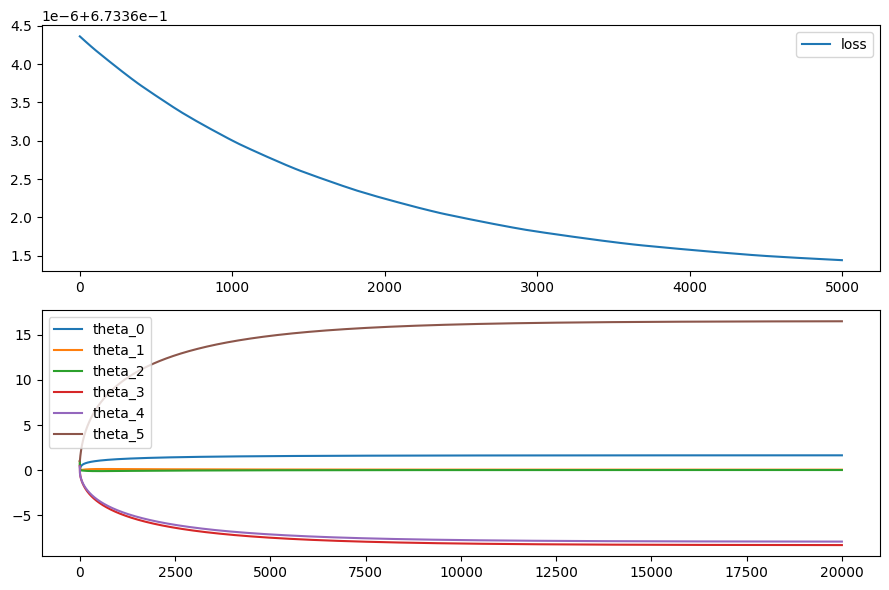

theta:  tensor([ 1.6459,  0.0565,  0.0182, -8.2916, -7.9045, 16.4859],
       requires_grad=True)


In [5]:
fig, axs = plt.subplots(2, 1, figsize=(9, 6))

# Plot loss history in the first subplot
axs[0].plot(loss_history[-5000:], label='loss')
axs[0].legend()

# Plot theta history in the second subplot
axs[1].plot(theta_history, label='theta')
axs[1].legend(['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5'])

plt.tight_layout()
plt.show()
print('theta: ', theta) # tensor([ 1.3524, -0.0822,  0.1119, -6.8440, -6.5374, 13.7761]

Text(0.5, 1.0, 'Estimated ratio $\\hat{r}=\\beta *\\phi(x_1,x_2)$')

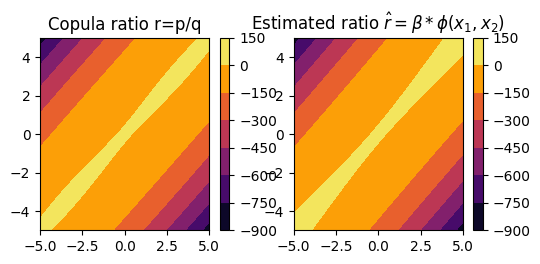

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))  

# Plot of Gaussian Copula ratio r=p/q
px = scs.multivariate_normal.logpdf(x = uvinput, mean = [0,0], cov = [[1,0.97],[0.97,1]])-scs.t(10).logpdf(x = uvinput[:,0])-scs.t(10).logpdf(x = uvinput[:,1])
contour_plot = axs[0].contourf(xgrid.numpy(), ygrid.numpy(), px.reshape(100, 100), cmap='inferno')
fig.colorbar(contour_plot, ax=axs[0]) 
axs[0].set_title('Copula ratio r=p/q')

# Plot of ratio 
ratio = log_ratio(theta = theta, data = uvinput).detach().numpy()
ratio_plot = axs[1].contourf(xgrid.numpy(), ygrid.numpy(), ratio.reshape(100, 100), cmap='inferno')
fig.colorbar(ratio_plot, ax=axs[1])
axs[1].set_title(r'Estimated ratio $\hat{r}=\beta *\phi(x_1,x_2)$')